In [1]:
#Libraries
using Gen
using PyPlot
using Distributions
using LinearAlgebra
using Flux
using Random
using Distances;

In [134]:
#Hyperparameters
n = 50
N = n*4
σₐ = 0.02
σᵧ = 1.0 #Likelihood variance
α = 0.09 #"Regularization" Term for NN Parameters
σₖ = sqrt(1/α) #Gaussian Variance for NN Parameters
k_range = 12
k_list = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12] #November 3
k_list_lite = [i for i in 1:k_range];

#Successful Hyperparameters - December 7th
#n = 50
#N = n*4
#σₐ = 0.02
#σᵧ = 1.0 #Likelihood variance
#α = 0.9 #"Regularization" Term for NN Parameters
#σₖ = sqrt(1/α) #Gaussian Variance for NN Parameters
#k_range = 12
#k_list = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12] #November 3
#k_list_lite = [i for i in 1:k_range];

L_within=10
eps_within=uniform(0.1,0.15)
L_across=20
eps_across=uniform(0.01,0.15)
across_iters=10;

#Birth/Death: Standard Death, Birth --> insert node at random location
#To-do: Random neuron death!

In [135]:
#Functions
function plot_data(data,classes,alpha=1.0)
    markers = ["o","*"]
    colors = ["blue","green"]
    for i=1:2
        mask = [classes[j] == i for j in 1:length(classes)]
        scatter(data[:,1][mask],data[:,2][mask],c=colors[i],alpha=alpha,marker=markers[i],zorder=3)
    end
end;

function unpack(Θ,k)
    m = length(Θ)
    h = 2*k
    Wₕ = reshape(Θ[1:h], k, 2);   
    bₕ = reshape(Θ[h+1:h+k], k)
    #bₕ = reshape(zeros(k), k)
    
    Wₒ = reshape(Θ[h+k+1:m-1], 1, k);
    bₒ = Θ[m]
    #bₒ = 0.0
      
    return Wₕ, bₕ, Wₒ, bₒ
end

function data_labeller(y::Array{Float64})
    labels = [y[i] > 0.5 ? 2 : 1 for i=1:length(y)]
    return labels
end

function trace_acc(trace)
    Wₕ = trace[:Wₕ]
    Wₒ = trace[:Wₒ]
    bₕ = trace[:bₕ]
    bₒ = trace[:bₒ]
    k = trace[:k]
    pred_y = G(data,Wₕ,bₕ,Wₒ,bₒ,k)
    pred_labels = data_labeller(pred_y)
    acc = sum([classes[i] == pred_labels[i] for i=1:length(classes)])
    return acc
end

mₖ(k) = k*4 + 1;

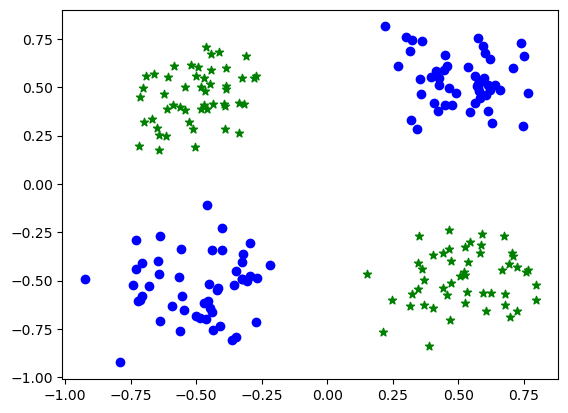

In [244]:
#Generate XOR Data
function real_data(N::Int, modes::Int, σ::Float64)
    μ₁ = [-0.5, -0.5]
    μ₂ = [-0.5, 0.5]
    μ₃ = [0.5, 0.5]
    μ₄ = [0.5, -0.5]
    #μ₅ = [1.25, 1.25]
    #μ₆ = [1.25, 1.75]
    #μ₇ = [1.75, 1.75]
    #μ₈ = [1.75, 1.25]
    μ = [μ₁, μ₂, μ₃, μ₄]
    Σ = [[σ, 0] [0, σ]]
    
    all_samples = zeros(Float64, (N*modes, 2))
    classes = zeros(Int, (N*modes))
    
    for i = 1:modes
        dist = MvNormal(μ[i], Σ)
        sample = rand(dist, N)::Matrix
        #scatter(sample[1,:],sample[2,:])
        all_samples[(i-1)*N+1:i*N,:] = transpose(sample)
        classes[(i-1)*N+1:i*N] = fill(i, N)
        classes = float(classes)
    end
    return all_samples, classes
end
    
data_raw, classes = real_data(Int(N/4), 4, σₐ);
classes = [(i+1) % 2 + 1 for i in classes]

plot_data(data_raw,classes)
data = transpose(data_raw)
size(data);

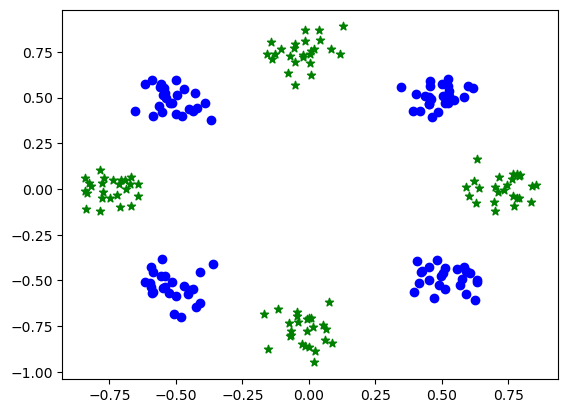

(2, 200)

In [76]:
#Scale up - Fixed Separable Data - Multi-XOR Data
function real_data(N::Int, modes::Int, σ::Float64)
    a = 1
    μ₁ = [-0.5, -0.5].*a
    μ₂ = [-0.75, 0.0].*a
    μ₃ = [-0.5, 0.5].*a
    μ₄ = [0.0, 0.75].*a
    μ₅ = [0.5, 0.5].*a
    μ₆ = [0.75, 0.0].*a
    μ₇ = [0.5, -0.5].*a
    μ₈ = [0.0, -0.75].*a
    μ = [μ₁, μ₂, μ₃, μ₄, μ₅, μ₆, μ₇, μ₈]
    Σ = [[σ*0.25, 0] [0, σ*0.25]]
    
    all_samples = zeros(Float64, (N*modes, 2))
    classes = zeros(Int, (N*modes))
    
    for i = 1:modes
        dist = MvNormal(μ[i], Σ)
        sample = rand(dist, N)::Matrix
        #scatter(sample[1,:],sample[2,:])
        all_samples[(i-1)*N+1:i*N,:] = transpose(sample)
        classes[(i-1)*N+1:i*N] = fill(i, N)
        classes = float(classes)
    end
    return all_samples, classes
end
    
data_raw, classes = real_data(Int(N/8), 8, σₐ);
classes = [(i+1) % 2 + 1 for i in classes]

plot_data(data_raw,classes)
data = transpose(data_raw)
size(data)

In [263]:
#Bayesian Neural Net
function G(x, W₁, b₁, W₂, b₂, k::Int)
    if(typeof(x) == Float64)
        x = [x]
    end
    
    W₁ = reshape(W₁, k, 2)
    W₂ = reshape(W₂, 1, k)
    b₁ = reshape(b₁, k)
    b₂ = reshape(b₂, 1)
    
    nn = Chain(Dense(W₁, b₁, relu),
               Dense(W₂, b₂))
    return nn(x)
end;

@gen function classifier(x::Array{Float64})
    α = 0.9 #"Regularization" Term
    σₖ = sqrt(1/α) #Gaussian Variance
    
    k ~ uniform_discrete(1,k_range) #Number of hidden nodes
    #k ~ k_count(1,0.5,1) #Shifted Negative Binomial
    #println(k)
    
    #Create individual weight and bias vectors
    m = mₖ(k)
    h = 2*k
    
    #Hidden Weights
    μ₁ = zeros(h)
    Σ₁ = Diagonal([σₖ for i=1:length(μ₁)])
    Wₕ ~ mvnormal(μ₁,Σ₁)
    
    #Hidden Bias
    μ₂ = ones(k)
    Σ₂ = Diagonal([σₖ for i=1:length(μ₂)])
    bₕ ~ mvnormal(μ₂,Σ₂)
    
    #Output Weights
    μ₃ = zeros(k)
    Σ₃ = Diagonal([σₖ for i=1:length(μ₃)])
    Wₒ ~ mvnormal(μ₃,Σ₃)
    
    #Output Bias
    μ₄ = ones(1)
    Σ₄ = Diagonal([σₖ for i=1:length(μ₄)])
    bₒ ~ mvnormal(μ₄,Σ₄)

    
    #Return Network Scores for X
    scores = Flux.sigmoid.(G(x,Wₕ,bₕ,Wₒ,bₒ,k))
    
    #Logistic Regression Likelihood
    #y = @trace(mvnormal(vec(scores), Diagonal([σᵧ for i=1:length(x[1,:])])), (:y))
    y = zeros(length(scores))
    for j=1:N
        y[j] = @trace(categorical([1-scores[j],scores[j]]), (:y,j))
    end

    return scores
    
end;

7


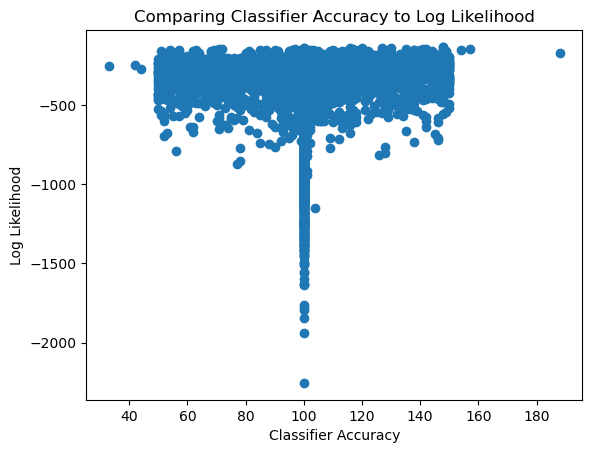

Acc: 148, Score: -136.6448046626257
Acc: 148, Score: -134.27420163791592


In [264]:
#Plot of Log Likelihood Scores
y_samp = classes
x_samp = data
obs_master = choicemap()::ChoiceMap
for i=1:length(classes)
    obs_master[(:y,i)] = classes[i]
end
obs = obs_master

scores = []
accs = []
distances = []
best_ks = []
ks = []

(best_trace,) = generate(classifier, (x_samp,), obs)
best_score = get_score(best_trace)
best_Wₕ = best_trace[:Wₕ]
best_Wₒ = best_trace[:Wₒ]
best_bₕ = best_trace[:bₕ]
best_bₒ = best_trace[:bₒ]
best_k = best_trace[:k]
println(best_k)

best_pred_y = G(data,best_Wₕ,best_Wₒ,best_bₕ,best_bₒ,best_k)
best_pred_labels = data_labeller(best_pred_y)
best_acc = sum([classes[i] == best_pred_labels[i] for i=1:length(classes)])
best_dist = euclidean(best_pred_y, classes)


function likelihood(best_trace, best_dist, best_score, best_k, best_acc)
    x_samp, y_samp = data, classes
    obs_master = choicemap()::ChoiceMap
    for i=1:length(classes)
        obs_master[(:y,i)] = classes[i]
    end
    obs = obs_master
    obs[:k] = best_trace[:k]
    (trace,) = generate(classifier, (x_samp,), obs)
    
    Wₕ = trace[:Wₕ]
    Wₒ = trace[:Wₒ]
    bₕ = trace[:bₕ]
    bₒ = trace[:bₒ]
    k = trace[:k]
    pred_y = G(data,Wₕ,bₕ,Wₒ,bₒ,k)
    pred_labels = data_labeller(pred_y)
    #println(pred_labels)

    acc = sum([classes[i] == pred_labels[i] for i=1:length(classes)])
    #println(acc)
    dist = euclidean(pred_y, classes)
    score = get_score(trace)
    #println(score)
    if score > best_score
        best_acc = acc
        best_score = score
        best_k = k
        best_trace = trace
        best_dist = dist
        best_pred_labels = pred_labels
    end
    push!(scores,score)
    push!(accs,acc)
    push!(distances, dist)
    push!(ks, k)
    
    return(best_trace, best_dist, best_score, best_k, best_acc)
end

#Testing specific k value
obs = obs_master
obs[:k] = 1
(best_trace2,) = generate(classifier, (x_samp,), obs)
best_acc2 = 0 
for i=1:500
    best_trace2, best_dist, best_score, best_k, best_acc2 = likelihood(best_trace2, best_dist, best_score, best_k, best_acc2)
    push!(best_ks, best_k)
end

obs = obs_master
obs[:k] = 9
best_acc3 = 0
(best_trace3,) = generate(classifier, (x_samp,), obs)
best_score2 = get_score(best_trace3)
for i=1:5000
    best_trace3, best_dist, best_score2, best_k, best_acc3 = likelihood(best_trace3, best_dist, best_score2, best_k, best_acc3)
    push!(best_ks, best_k)
    #println(best_acc3)
end

scatter(accs,scores)
#plt.ylim(-500,0.0)
#plt.xlim(400,800)
plt.title("Comparing Classifier Accuracy to Log Likelihood")
plt.xlabel("Classifier Accuracy")
plt.ylabel("Log Likelihood");
#println(best_ks[10000])
#println(best_score)
println("Acc: $best_acc2, Score: $best_score")
println("Acc: $best_acc3, Score: $best_score2")
#println(best_pred_labels)
#println(classes)

In [265]:
#Compare 2 and 3 Node Network
println(get_score(best_trace2))
println(get_score(best_trace3))
a2 = best_trace2[:Wₕ]
b2 = best_trace2[:Wₒ]
c2 = best_trace2[:bₕ]
d2 = best_trace2[:bₒ]

a3 = best_trace3[:Wₕ]
b3 = best_trace3[:Wₒ]
c3 = best_trace3[:bₕ]
d3 = best_trace3[:bₒ]

println(a2)
println(a3)
best_trace = best_trace3

-136.6448046626257
-134.27420163791592
[1.6431088545926598, 1.2165535809368273]
[0.7796730646501963, 1.5608150471295201, -0.4451659822213076, -1.0311411936338535, -2.118444867894011, 0.590092830347759, -0.6393250346964662, -0.6822119219047792, 1.8116621919654272, 0.3715995363186013, 1.3494349039010327, 1.8444916309815484, 1.9913691382432515, 1.8636173312646767, -0.20501972366894075, 1.1916145742667381, 0.5746777472586562, -0.9806950936337822]


Gen.DynamicDSLTrace{DynamicDSLFunction{Any}}(DynamicDSLFunction{Any}(Dict{Symbol,Any}(), Dict{Symbol,Any}(), Type[Array{Float64,N} where N], false, Union{Nothing, Some{Any}}[nothing], ##classifier#414, Bool[0], false), Trie{Any,Gen.ChoiceOrCallRecord}(Dict{Any,Gen.ChoiceOrCallRecord}((:y, 74) => Gen.ChoiceOrCallRecord{Int64}(2, -0.39741409662138555, NaN, true),(:y, 191) => Gen.ChoiceOrCallRecord{Int64}(2, -0.49056206067586255, NaN, true),(:y, 105) => Gen.ChoiceOrCallRecord{Int64}(1, -0.14531441683850554, NaN, true),(:y, 20) => Gen.ChoiceOrCallRecord{Int64}(1, -0.2681089596526996, NaN, true),(:y, 51) => Gen.ChoiceOrCallRecord{Int64}(2, -0.23101497858867942, NaN, true),(:y, 6) => Gen.ChoiceOrCallRecord{Int64}(1, -0.3694662317647856, NaN, true),(:y, 73) => Gen.ChoiceOrCallRecord{Int64}(2, -0.633086634523763, NaN, true),(:y, 123) => Gen.ChoiceOrCallRecord{Int64}(1, -0.19999781657985635, NaN, true),(:y, 187) => Gen.ChoiceOrCallRecord{Int64}(2, -0.5104209668386102, NaN, true),(:y, 144) => Ge

In [266]:
#Test out Birth and Death Moves for NN
a = best_trace[:Wₕ]
b = best_trace[:Wₒ]
c = best_trace[:bₕ]
d = best_trace[:bₒ]
k = best_trace[:k]
new_k = k+1

difference = abs(new_k - k)
a2 = vcat(a,[0 for i=1:(2*difference)])
b2 = vcat(b,[0 for i=1:difference])
c2 = vcat(c,[1 for i=1:difference])
d2 = d

a2 = zeros(length(a2))
b2 = zeros(length(b2))
c2 = zeros(length(c2))
d2 = zeros(length(d2))

pred_y = G(data,a2,b2,c2,d2,new_k)
pred_labels = data_labeller(pred_y)
acc = sum([classes[i] == pred_labels[i] for i=1:length(classes)])
println(acc)

obs_new = choicemap()::ChoiceMap
obs_new[:Wₕ] = a2
obs_new[:Wₒ] = b2
obs_new[:bₕ] = c2
obs_new[:bₒ] = d2
obs_new[:k] = new_k

for i=1:length(classes)
    obs_new[(:y,i)] = classes[i]
end
(new_trace, weight) = generate(classifier, (x_samp,), obs_new)

println(a)
println(b)
println(c)
println(d)

println(a2)
println(b2)
println(c2)
println(d2)
println(get_score(best_trace))
println(best_score)
typeof(best_score)
println(get_score(new_trace))
typeof(get_score(new_trace))

100
[0.7796730646501963, 1.5608150471295201, -0.4451659822213076, -1.0311411936338535, -2.118444867894011, 0.590092830347759, -0.6393250346964662, -0.6822119219047792, 1.8116621919654272, 0.3715995363186013, 1.3494349039010327, 1.8444916309815484, 1.9913691382432515, 1.8636173312646767, -0.20501972366894075, 1.1916145742667381, 0.5746777472586562, -0.9806950936337822]
[-1.38597276956744, -0.95109717445704, 0.40397915984075977, 1.0415632620290078, 0.34250607394508237, 0.15701837743569855, 0.3362255925139195, -0.2830204883271161, 1.8170369597910192]
[2.485028366577443, 0.01809852034656334, 1.326733116209279, 0.00684131387641973, 1.5208133860319668, 1.4829408403982574, 1.4248361328360513, 0.40292372914025176, 0.3653479727025797]
[0.06778852544938685]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.0]
-134.27420163791592
-136.64480466

Float64

In [267]:
#Need to find a way to propose birth/death moves instead of any k
function birth_or_death(trace)
    current_k = trace[:k]
    if current_k == last(k_list)
        new_trace = death(trace)
    elseif current_k == k_list[1]
        new_trace = birth(trace)
    else
        new_trace = bernoulli(0.5) ? birth(trace) : death(trace)
    end
    #new_trace = bernoulli(0.5) ? birth_or_death(new_trace) : new_trace
    return new_trace    
end

@gen function birth(trace)
    previous_k = trace[:k]
    new_k = k_list[previous_k + 1]
    difference = abs(new_k - previous_k)
    
    #Old Parameters - Deep Copy
    Wₕ = [trace[:Wₕ][i] for i=1:length(trace[:Wₕ])]
    Wₒ = [trace[:Wₒ][i] for i=1:length(trace[:Wₒ])]
    bₕ = [trace[:bₕ][i] for i=1:length(trace[:bₕ])]
    bₒ = [trace[:bₒ][i] for i=1:length(trace[:bₒ])]
    
    #Select Insertion Place for New Neuron
    insert = rand((1:new_k))
    #println(insert)
    
    obs_new = choicemap()::ChoiceMap
    for i=1:length(classes)
        obs_new[(:y,i)] = classes[i]
    end
    obs_new[:Wₕ] = vcat(Wₕ,[normal(0,σₖ) for i=1:(2*difference)])
    Wₕ = insert!(Wₕ, insert*2-1, normal(0,σₖ))
    obs_new[:Wₕ] = insert!(Wₕ, insert*2, normal(0,σₖ))
    #obs_new[:Wₒ] = vcat(Wₒ,[normal(0,σₖ) for i=1:difference])
    obs_new[:Wₒ] = insert!(Wₒ, insert, normal(0,σₖ))
    obs_new[:bₕ] = insert!(bₕ, insert, normal(1,σₖ))
    obs_new[:bₒ] = bₒ
    #new_Wₕ = vcat(Wₕ,[0 for i=1:(2*difference)])
    #new_Wₒ = vcat(Wₒ,[0 for i=1:difference])
    #new_bₕ = vcat(bₕ,[1 for i=1:difference])
    #new_bₒ = bₒ
    #obs_new[:Wₕ] = zeros(length(new_Wₕ))
    #obs_new[:Wₒ] = zeros(length(new_Wₒ))
    #obs_new[:bₕ] = zeros(length(new_bₕ))
    #obs_new[:bₒ] = zeros(length(new_bₒ))
    obs_new[:k] = new_k
    
    (new_trace, weight) = generate(classifier, (x_samp,), obs_new)
    
    #obs_new2 = choicemap()::ChoiceMap
    #for i=1:length(classes)
        #obs_new2[(:y,i)] = classes[i]
    #end
    #obs_new2[:k] = new_k
    #(new_trace2, weight) = generate(classifier, (x_samp,), obs_new2)
    
    return new_trace

end

@gen function death(trace)
    
    previous_k = trace[:k]
    new_k = k_list[previous_k - 1]
    #new_k = previous_k - 1
    difference = abs(previous_k - new_k)
    
    #Old Parameters - Deep Copy
    Wₕ = [trace[:Wₕ][i] for i=1:length(trace[:Wₕ])]
    Wₒ = [trace[:Wₒ][i] for i=1:length(trace[:Wₒ])]
    bₕ = [trace[:bₕ][i] for i=1:length(trace[:bₕ])]
    bₒ = [trace[:bₒ][i] for i=1:length(trace[:bₒ])]
    
    #Select Deletion Place for Removed Neuron
    delete = rand((1:previous_k))
    
    #Create new choicemap and fill with real Y values
    obs_new = choicemap()::ChoiceMap
    obs_new[:y] = y_samp
    
    #Adjust parameter vectors
    Wₕ = deleteat!(Wₕ, delete*2-1)
    obs_new[:Wₕ] = deleteat!(Wₕ, delete*2-1)
    obs_new[:Wₒ] = deleteat!(Wₒ, delete)
    obs_new[:bₕ] = deleteat!(bₕ, delete)
    obs_new[:bₒ] = bₒ
    obs_new[:k] = new_k
    
    (new_trace, weight) = generate(classifier, (x_samp,), obs_new)
    return new_trace
end;

In [275]:
best_trace2 = birth_or_death(best_trace)
println(best_trace[:k])
println(best_trace2[:k])

scorea = get_score(best_trace)
scoreb = get_score(best_trace2)

a = best_trace[:Wₕ]
b = best_trace[:Wₒ]
c = best_trace[:bₕ]
d = best_trace[:bₒ]
k = best_trace[:k]

a2 = best_trace2[:Wₕ]
b2 = best_trace2[:Wₒ]
c2 = best_trace2[:bₕ]
d2 = best_trace2[:bₒ]
k2 = best_trace2[:k]

pred_y = G(data,a,c,b,d,k)
pred_labels = data_labeller(pred_y)
acc = sum([classes[i] == pred_labels[i] for i=1:length(classes)])
pred_y = G(data,a2,c2,b2,d2,k2)
pred_labels = data_labeller(pred_y)
acc2 = sum([classes[i] == pred_labels[i] for i=1:length(classes)])

#println(best_trace[:Wₕ])
#println(best_trace2[:Wₕ])
println(best_trace[:Wₒ])
println(best_trace2[:Wₒ])

println(scorea)
println(acc)
println(scoreb)
println(acc2)

9
8
[-1.38597276956744, -0.95109717445704, 0.40397915984075977, 1.0415632620290078, 0.34250607394508237, 0.15701837743569855, 0.3362255925139195, -0.2830204883271161, 1.8170369597910192]
[-1.38597276956744, 0.40397915984075977, 1.0415632620290078, 0.34250607394508237, 0.15701837743569855, 0.3362255925139195, -0.2830204883271161, 1.8170369597910192]
-134.27420163791592
148
-163.97138728433092
109


In [238]:
scorebs = []
best_trace2 = best_trace



for i = 1:3
    best_trace2 = birth(best_trace2)
    push!(scorebs, get_score(best_trace2))
end

for i = 1:3
    best_trace2 = death(best_trace2)
    push!(scorebs, get_score(best_trace2))
end


scorea = get_score(best_trace)
scoreb = get_score(best_trace2)

println(scorea)
println(scoreb)
println(scorebs)


-Inf
-23.85200675550067
Any[-Inf, -Inf, -Inf, -50.486029972605024, -33.19562243217716, -23.85200675550067]


In [243]:
traces = []
acc = []
acc_a = []
acc_w = []
ks = []

function within_dimension(trace, iters)
    for i=1:iters
        (trace, accepted) = hmc(trace, select(:Wₕ,:bₕ,:Wₒ,:bₒ), L=10, eps=uniform(0.1,0.15), check=false, observations=obs)
        #println("Within dimension: $(trace[:k])")
        push!(traces, trace)
        push!(acc, accepted)
        push!(acc_w, accepted)
    end
    return trace
end
eps_list = []
function across_dimension(trace, iters, obs)
    
    new_trace = birth_or_death(trace)
    score_test = get_score(new_trace)
    
    #test = true
    for i=1:iters
        eps = uniform(0.01,0.15)
        (new_trace, accepted) = hmc(new_trace, select(:Wₕ,:bₕ,:Wₒ,:bₒ), L=20, eps=eps, observations=obs)
        #(new_trace, accepted) = hmc(new_trace, select(:Wₕ,:bₕ,:Wₒ,:bₒ), L=10, eps=0.02, check=false, observations=obs)
        #accepted && (test = false)
        accepted && (push!(eps_list,eps))
    end
    #test && println("Nothing accepted")
    #test == false && println("Accepted")
    
    #test = true
    score1 = get_score(trace)
    score2 = get_score(new_trace)
    score = exp(score2-score1)
    println("Old Trace: $score1; Pre-HMC: $score_test; Post-HMC: $score2")
    
    if rand(Uniform(0,1)) < score
        accepted = true
        trace = new_trace
        new_k = trace[:k]
        println("New k accepted! Current k: $(new_k)")
    else
        #println("Sticking with the old k!")
        accepted = false
    end
    
    obs = obs_master
    obs[:k] = trace[:k]
        
    push!(traces, trace)
    push!(acc, accepted)
    push!(acc_a, accepted)
    return trace, trace[:k]
end

function rjmcmc(starting_trace, iters)
    trace = starting_trace
    k = obs[:k]
    println("Beginning RJMCMC. Starting k: $k")
    #@showprogress 1 "Sampling..." for i = 1:iters
    for i=1:iters

        if (i%100 == 0)
            #current_acc = (sum(acc[length(acc)-10:length(acc)])/11)
            across_acc = (sum(acc_a)/length(acc_a))
            within_acc = (sum(acc_w)/length(acc_w))
            println("Epoch $i Across Acceptance Prob: $across_acc")
            println("Epoch $i Within Acceptance Prob: $within_acc")
        end
        
        if rand(Uniform(0,1)) > 0.5
            (trace, k) = across_dimension(trace, 10, obs)
        else
            (trace) = within_dimension(trace, 1)
        end
        push!(ks, k)
    end
    println("Finished")
end
 
runs = 20000
starting_trace = best_trace
x_samp, y_samp = data, classes
obs_master = choicemap()::ChoiceMap
for i=1:length(classes)
    obs_master[(:y,i)] = classes[i]
end
obs = obs_master
#obs_master[:y] = y_samp .- 1
obs = obs_master;

#(starting_trace,) = generate(classifier, (x_samp,), obs)
obs[:k] = starting_trace[:k]
rjmcmc(starting_trace,runs);

Beginning RJMCMC. Starting k: 8
Old Trace: -Inf; Pre-HMC: -111.75971482592695; Post-HMC: -112.05895496803491
New k accepted! Current k: 7
Old Trace: -112.05895496803491; Pre-HMC: -Inf; Post-HMC: -Inf
Old Trace: -112.05895496803491; Pre-HMC: -Inf; Post-HMC: -Inf
Old Trace: -112.05895496803491; Pre-HMC: -Inf; Post-HMC: -Inf
Old Trace: -112.05895496803491; Pre-HMC: -94.05502552489395; Post-HMC: -97.11275374030096
New k accepted! Current k: 6
Old Trace: -96.13430738733935; Pre-HMC: -Inf; Post-HMC: -Inf
Old Trace: -95.48346060562068; Pre-HMC: -83.63258381089672; Post-HMC: -84.70823198880666
New k accepted! Current k: 5
Old Trace: -84.70823198880666; Pre-HMC: -Inf; Post-HMC: -Inf
Old Trace: -84.70823198880666; Pre-HMC: -Inf; Post-HMC: -Inf
Old Trace: -84.70823198880666; Pre-HMC: -64.45877951210132; Post-HMC: -65.36835701850094
New k accepted! Current k: 4
Old Trace: -66.06761272060716; Pre-HMC: -50.664900618907765; Post-HMC: -54.46636786802111
New k accepted! Current k: 3
Old Trace: -54.4663

InterruptException: InterruptException:

In [210]:
eps_list

119-element Array{Any,1}:
 0.058517479473643864
 0.0399943260259767
 0.012722681272593399
 0.04272648801984578
 0.1008152043943644
 0.09048991875062966
 0.051965468791727636
 0.07791054879196536
 0.14400943727138538
 0.04443267020568004
 0.11906540709692885
 0.09804463724826488
 0.03069060008164371
 ⋮
 0.04817071720222004
 0.08681579581705019
 0.08154935173556824
 0.06370344871960364
 0.1148345748648105
 0.05825429818653429
 0.019421303147847926
 0.13157122525484422
 0.024858520423644517
 0.14531762807763912
 0.06808480306574315
 0.13434161003265505

In [585]:
[obs[:y][i] == classes for i=1:length(classes)]
#print(classes)
print(obs[:y])

KeyError: KeyError: key :y not found

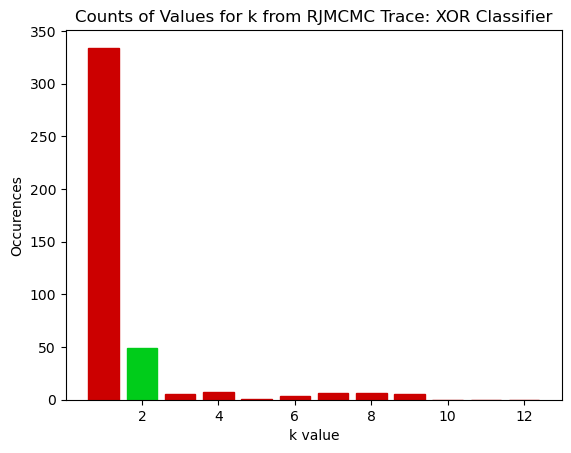

In [211]:
#Bar Plot of k estimates
#ks = [traces[i][:k] for i in 1:length(traces)]
counts = [sum([ks[i] == j for i in 1:length(ks)]) for j in k_list]
#actual_ks = [i for i=1:maximum(ks)]
barlist=bar(k_list,counts)
for i in 1:k_range
    barlist[i].set_color([0.8,0.0,0.0])
end
barlist[2].set_color([0.0,0.8,0.1])

plt.title("Counts of Values for k from RJMCMC Trace: XOR Classifier")
plt.xlabel("k value")
plt.ylabel("Occurences");

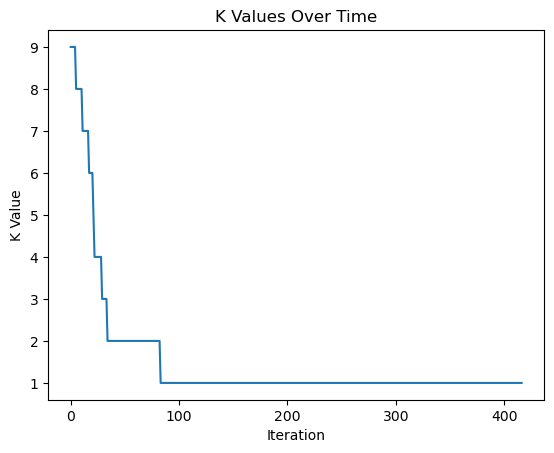

PyObject Text(24.000000000000007, 0.5, 'K Value')

In [212]:
plot(ks)
plt.title("K Values Over Time")
plt.xlabel("Iteration")
plt.ylabel("K Value")

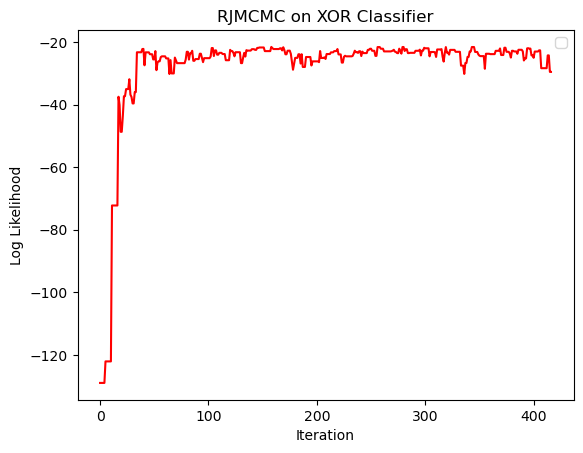

No handles with labels found to put in legend.


In [213]:
#hmc_traces_master = vcat(hmc_traces, hmc_traces2, hmc_traces3, hmc_traces4);
best_result = best_trace
scores2 = zeros(length(traces))
for i=1:length(traces)
    trace = traces[i]
    obs = obs_master
    scores2[i] = get_score(trace)
    if get_score(trace) > get_score(best_result)
        best_result = trace
    end
end
plot(scores2, color="red")
#plot(scores2, color="green")
plt.title("RJMCMC on XOR Classifier")
plt.xlabel("Iteration")
plt.ylabel("Log Likelihood")
#plt.axvline(100,label="Burn-In: ~1000",color="red")
plt.legend();

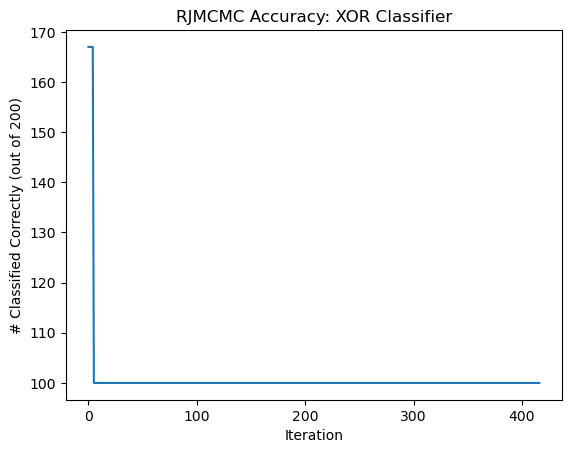

PyObject Text(24.000000000000007, 0.5, '# Classified Correctly (out of 200)')

In [214]:
accs = []
for i=1:length(traces)
    trace = traces[i]
    Wₕ = trace[:Wₕ]
    Wₒ = trace[:Wₒ]
    bₕ = trace[:bₕ]
    bₒ = trace[:bₒ]
    k = trace[:k]
    
    pred_y = G(data,Wₕ,bₕ,Wₒ,bₒ,k)
    pred_labels = data_labeller(pred_y)
    
    acc = acc = sum([classes[i] == pred_labels[i] for i=1:length(classes)])
    push!(accs,acc)
end

plot(accs)
plt.title("RJMCMC Accuracy: XOR Classifier")
plt.xlabel("Iteration")
plt.ylabel("# Classified Correctly (out of 200)")

┌ Info: Saved animation to 
│   fn = /home/jberez/Projects/RJMCMC/anim_fps_xor2.gif
└ @ Plots /home/jberez/.julia/packages/Plots/4EfKl/src/animation.jl:104


Plots.AnimatedGif("/home/jberez/Projects/RJMCMC/anim_fps_xor2.gif")
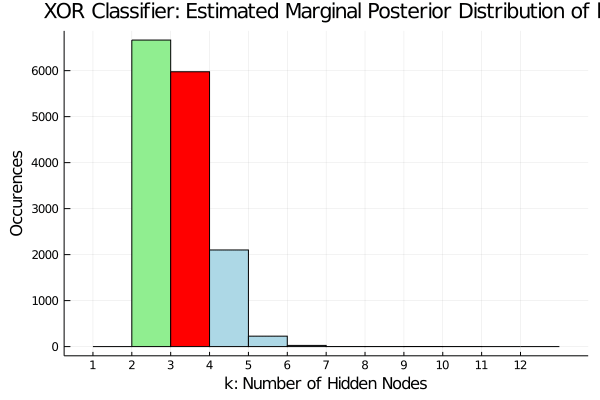

In [125]:
#Try Dynamic Plotting
using Plots
anim = @animate for i ∈ 15000:10:runs
    colors = ["lightblue" for i=1:k_range]
    colors[2] = "lightgreen"
    colors[ks[i]] = "red"
    Plots.histogram(
        ks[1:i], 
        bins=1:k_range+1,
        fillcolor=colors,
        title="XOR Classifier: Estimated Marginal Posterior Distribution of k",
        xlabel="k: Number of Hidden Nodes",
        ylabel="Occurences",
        xticks = 0:1.0:12,
        legend=false
    )
end

gif(anim, "anim_fps_xor2.gif", fps = 2000000)

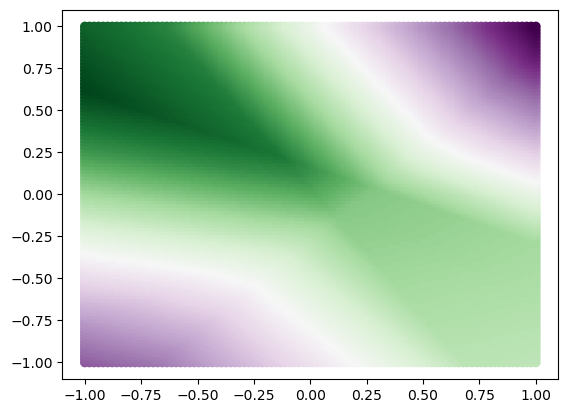

PyObject <matplotlib.collections.PathCollection object at 0x7fd02be55f90>

In [101]:
function plot_grid(data,scores,alpha=1.0)
    PyPlot.scatter(data[:,1],data[:,2],c=scores,alpha=alpha,cmap="PRGn")
    #PyPlot.colorbar()
end

function tracegrid(traces, samples=1000, low=-1.0, high=1.0)
    d=2
    n=100
    r = range(low, high, length = n)
    
    iter = Iterators.product((r for _ in 1:d)...)
    grid= vec([collect(i) for i in iter])
    grid_raw = reduce(hcat, getindex.(grid,i) for i in eachindex(grid[1]))
    grid2 = transpose(grid_raw)
    z_master = zeros(length(grid2[1,:]))
    
    for i=1:samples
        j = rand((1,length(traces)))
        trace = traces[j]
        Wₕ = trace[:Wₕ]
        Wₒ = trace[:Wₒ]
        bₕ = trace[:bₕ]
        bₒ = trace[:bₒ]
        k = trace[:k]
        z = Flux.hardσ.(G(grid2,Wₕ,bₕ,Wₒ,bₒ,k),0.02)[1,:]
        z_master += (z ./ samples)
    end
    plot_grid(grid_raw, z_master)
end

tracegrid(traces)

In [123]:
for i ∈ 1500:10:1600
    println(i)
end

1500
1510
1520
1530
1540
1550
1560
1570
1580
1590
1600


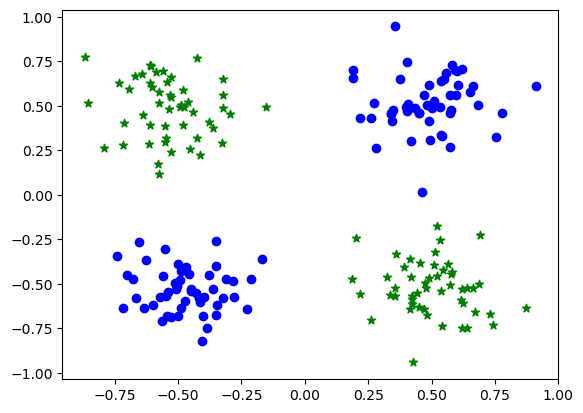

In [590]:
plot_data(data_raw,classes)